In [2]:

import sys
sys.path.append('/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from experiments import SimpleRNet, apply_threshold, CosineDistanceLoss, ManualCNN, HybridCosineDistanceCrossEntopyLoss
from matplotlib import pyplot as plt
import numpy as np
# comment out when running locally
from experiments import WrapperNet
# comment out when running locally            

/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
def train_model(model, optimizer, criterion, train_loader, device, attention_function):
    total_loss = 0
    model.train()
    for _ in range(10):
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device)
        target_map = attention_function(data, threshold=0.95) # threshold is 0.99
        optimizer.zero_grad()
        output_classification, output = model(data)
        loss = criterion(output, target_map, output_classification, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    return total_loss

def test_model(model, criterion, test_loader, device, attention_function):
    model.eval()
    test_loss = 0
    correct = 0
    total_seen = 0
    with torch.no_grad():
        for _ in range(10):
            data, target = next(iter(test_loader))
            data, target = data.to(device), target.to(device)
            target_map = attention_function(data, threshold=0.95)
            output_classification, output = model(data)
            test_loss += criterion(output, target_map, output_classification, target).item()
            correct += output_classification.argmax(dim=1).eq(target).sum().item()
            total_seen += len(target)
    test_loss /= total_seen
    accuracy = (correct / total_seen) * 100
    return test_loss, accuracy    

def plot_heatmap_comparison(model, test_loader, device, attention_function, epoch):
    data, target = next(iter(test_loader))
    target_map = attention_function(data, threshold=0.95)
    output_classification, output = model(data.to(device), target.to(device))
    num = np.random.randint(0, len(target))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
    axes[0].set_title(f'LRP Output after {epoch} iterations')
    axes[1].imshow(target_map[num][0], cmap='hot')
    axes[1].set_title('Target Heatmap (Ground Truth)')
    axes[2].imshow(data[num][0].detach().numpy(), cmap='gray')
    axes[2].set_title('Input Image (Original)')
    plt.show()

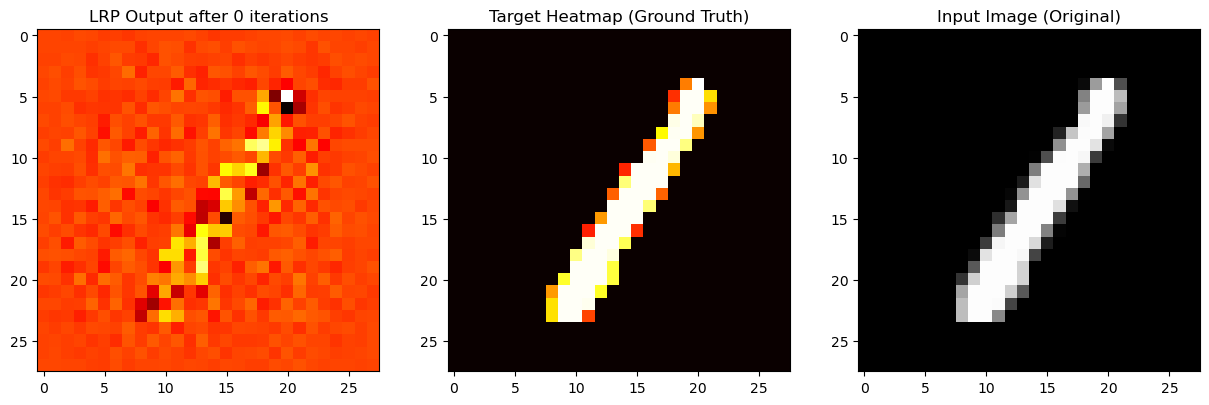

Epoch: 0, Test Classification Loss: 0.0359885185956955, Accuracy: 8.125
Epoch: 0, Training Loss: 0.00038242324193318687
Epoch: 1, Test Classification Loss: 0.03561957739293575, Accuracy: 38.125
Epoch: 1, Training Loss: 0.00037413039604822793
Epoch: 2, Test Classification Loss: 0.03429507687687874, Accuracy: 35.15625
Epoch: 2, Training Loss: 0.0003450902263323466
Epoch: 3, Test Classification Loss: 0.029215411096811295, Accuracy: 44.21875
Epoch: 3, Training Loss: 0.00030693912108739217
Epoch: 4, Test Classification Loss: 0.026860094256699087, Accuracy: 39.0625
Epoch: 4, Training Loss: 0.00026906609535217287


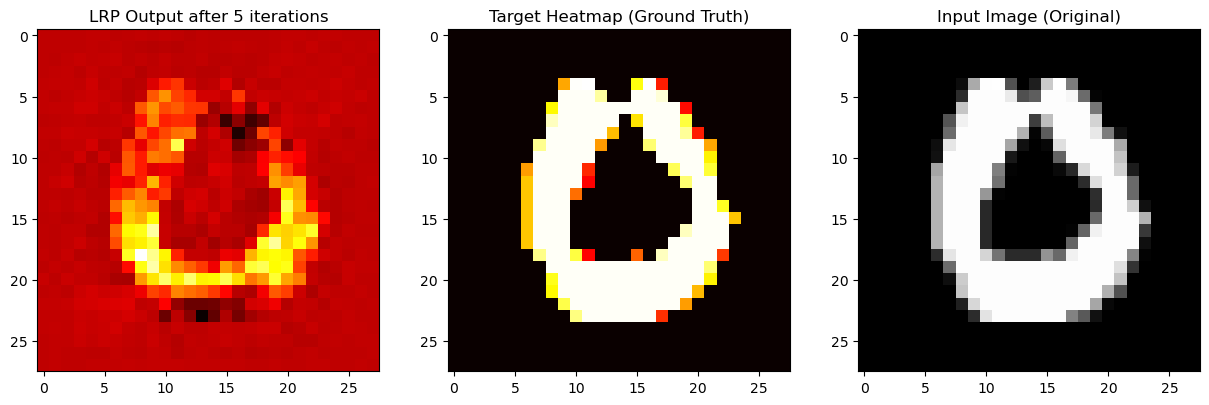

Epoch: 5, Test Classification Loss: 0.024428538978099823, Accuracy: 52.34375
Epoch: 5, Training Loss: 0.00024297312498092652
Epoch: 6, Test Classification Loss: 0.022906117700040342, Accuracy: 53.43750000000001
Epoch: 6, Training Loss: 0.00024787325859069824
Epoch: 7, Test Classification Loss: 0.02072773203253746, Accuracy: 60.46875000000001
Epoch: 7, Training Loss: 0.00020237435301144918
Epoch: 8, Test Classification Loss: 0.018653040751814842, Accuracy: 64.0625
Epoch: 8, Training Loss: 0.0001841238707304001
Epoch: 9, Test Classification Loss: 0.01704791272059083, Accuracy: 66.09375
Epoch: 9, Training Loss: 0.0001841752181450526


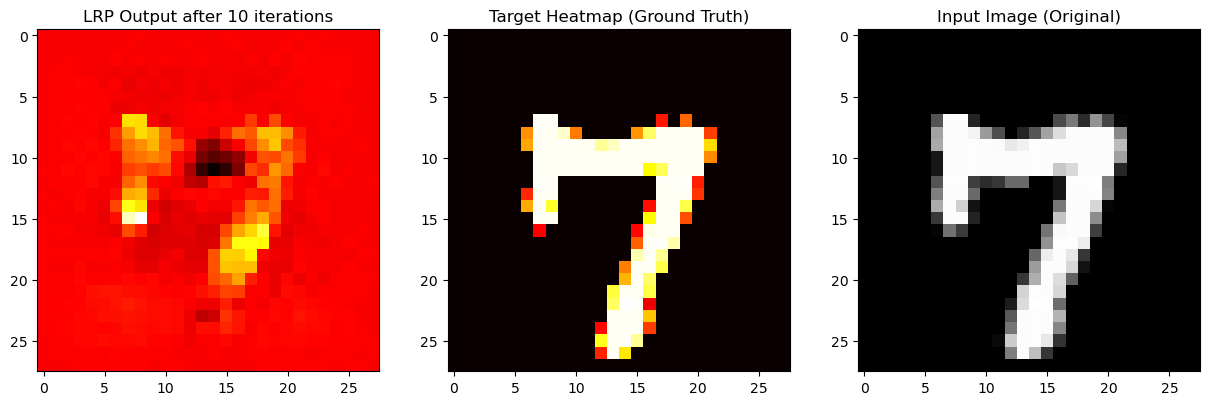

Epoch: 10, Test Classification Loss: 0.01561559857800603, Accuracy: 70.46875
Epoch: 10, Training Loss: 0.0001640762617190679
Epoch: 11, Test Classification Loss: 0.015055214706808328, Accuracy: 71.40625
Epoch: 11, Training Loss: 0.00014742570221424104
Epoch: 12, Test Classification Loss: 0.012735779490321874, Accuracy: 75.78125
Epoch: 12, Training Loss: 0.00013240295946598054
Epoch: 13, Test Classification Loss: 0.011957627534866334, Accuracy: 79.375
Epoch: 13, Training Loss: 0.00012004747688770294
Epoch: 14, Test Classification Loss: 0.011013051867485047, Accuracy: 80.15625
Epoch: 14, Training Loss: 0.00010814730276664097


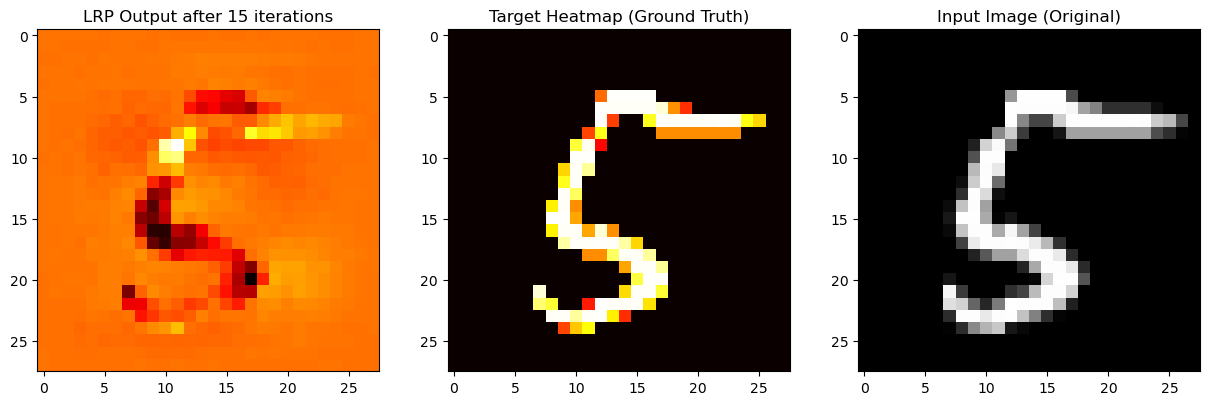

Epoch: 15, Test Classification Loss: 0.010691203735768795, Accuracy: 81.25
Epoch: 15, Training Loss: 0.00011937958896160126
Epoch: 16, Test Classification Loss: 0.010443259915336966, Accuracy: 80.78125
Epoch: 16, Training Loss: 0.00010781559695800146
Epoch: 17, Test Classification Loss: 0.009509488102048635, Accuracy: 83.4375
Epoch: 17, Training Loss: 0.0001043623760342598
Epoch: 18, Test Classification Loss: 0.008702796697616578, Accuracy: 84.6875
Epoch: 18, Training Loss: 0.0001121475413441658
Epoch: 19, Test Classification Loss: 0.009754737606272101, Accuracy: 82.96875
Epoch: 19, Training Loss: 0.00010527130564053853


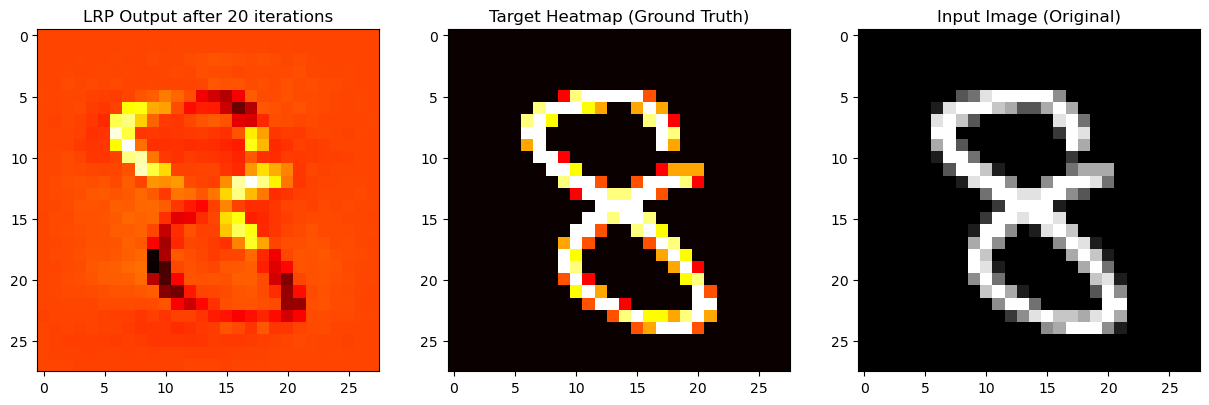

Epoch: 20, Test Classification Loss: 0.008386324252933263, Accuracy: 85.9375
Epoch: 20, Training Loss: 0.00010818870564301809
Epoch: 21, Test Classification Loss: 0.008092753728851676, Accuracy: 85.78125
Epoch: 21, Training Loss: 9.340727478265763e-05


KeyboardInterrupt: 

In [6]:

# define device for GPU compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and transform datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network

# now wrap the network in the LRP class
model = WrapperNet(SimpleRNet(), hybrid_loss=True)
optimizer= optim.Adam(model.parameters(), lr=1e-4)

# define the loss functions for each
# lambda parameter weights cross entropy loss with CosineDistance. 
# The higher the lambda parameter, the more weight is given to the cosine distnace loss
criterion = HybridCosineDistanceCrossEntopyLoss(_lambda=0.0)
# Move to device
model.to(device)

EPOCHS = 100
VISUALIZE_FREQ = 5
for x in range(EPOCHS):
    if x % VISUALIZE_FREQ == 0:
        plot_heatmap_comparison(model, test_loader, device, apply_threshold, x)
    test_classification_loss, accuracy = test_model(model, criterion, test_loader, device, apply_threshold)
    print(f'Epoch: {x}, Test Classification Loss: {test_classification_loss}, Accuracy: {accuracy}')
    train_loss = train_model(model, optimizer, criterion, train_loader, device, apply_threshold)
    print(f'Epoch: {x}, Training Loss: {train_loss}')
    
